In [123]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [124]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [125]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [126]:
def FindMissingData(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().sum().sum()*100).sort_values(ascending = False)
    
    ms = pd.concat([total,percent], axis = 1, keys = ['Total', 'Percent'])
    ms = ms[ms['Percent'] > 0]
    
    return ms
    
    

In [127]:
FindMissingData(train_df)

,Total,Percent
Cabin,687,79.330254
Age,177,20.438799
Embarked,2,0.230947


In [128]:
FindMissingData(test_df)

,Total,Percent
Cabin,327,78.985507
Age,86,20.772947
Fare,1,0.241546


In [129]:
drop_column = ['Cabin']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column,axis=1,inplace=True)

In [130]:
train_df['Age'].fillna(train_df['Age'].median(),inplace = True)
test_df['Age'].fillna(test_df['Age'].median(),inplace = True)

In [131]:
FindMissingData(train_df)

,Total,Percent
Embarked,2,100.0


In [132]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace = True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0],inplace = True)

In [133]:
FindMissingData(train_df)

,Total,Percent


In [134]:
all_data = [train_df, test_df]

In [135]:
for data in all_data:
    data['Family'] = data['Parch'] + data['SibSp'] + 1


In [136]:
import re

def getTitle(name):
    titleSearch = re.search(' ([A-Za-z]+)\.', name)
    
    if titleSearch :
        return titleSearch.group(1)
    
    return ""

for data in all_data:
    data['Title'] = data['Name'].apply(getTitle)
    
for data in all_data:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle','Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    
    





In [137]:
for data in all_data:
    data['Age_bin'] = pd.cut(data['Age'], bins = [0,12,20,50,120], labels = ['Children','Teenagers','Adults', 'Old'])

In [138]:
for data in all_data:
    data['Fare_bin'] = pd.cut(data['Fare'], bins = [0,7.91,14.45,31,120], labels = ['Low_Fare', 'Median_Fare','Average_Fare','High_Fare'])

In [139]:
traindf = train_df
testdf = test_df

In [140]:
alldf = [traindf, testdf]

In [141]:

for data in alldf:
    drop_col = ['Age','Fare','Ticket', 'Name']
    data.drop( drop_col, axis =1, inplace = True)
    

In [142]:
drop_col = ['PassengerId']
traindf.drop(drop_col, axis = 1, inplace = True)

In [143]:
traindf.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Family,Title,Age_bin,Fare_bin
0,0,3,male,1,0,S,2,Mr,Adults,Low_Fare
1,1,1,female,1,0,C,2,Mrs,Adults,High_Fare
2,1,3,female,0,0,S,1,Miss,Adults,Median_Fare
3,1,1,female,1,0,S,2,Mrs,Adults,High_Fare
4,0,3,male,0,0,S,1,Mr,Adults,Median_Fare


In [144]:
traindf = pd.get_dummies(traindf, columns = ['Sex', 'Title','Age_bin','Fare_bin','Embarked'], prefix = ['Sex', 'Title','Age_bin','Fare_bin','Embarked'])

In [145]:
testdf = pd.get_dummies(testdf, columns = ['Sex', 'Title','Age_bin','Fare_bin','Embarked'], prefix = ['Sex', 'Title','Age_bin','Fare_bin','Embarked'])

In [146]:
traindf.head()

,Survived,Pclass,SibSp,Parch,Family,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_bin_Children,Age_bin_Teenagers,Age_bin_Adults,Age_bin_Old,Fare_bin_Low_Fare,Fare_bin_Median_Fare,Fare_bin_Average_Fare,Fare_bin_High_Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,0,2,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1
1,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0
2,1,3,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,1,1,1,0,2,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
4,0,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1


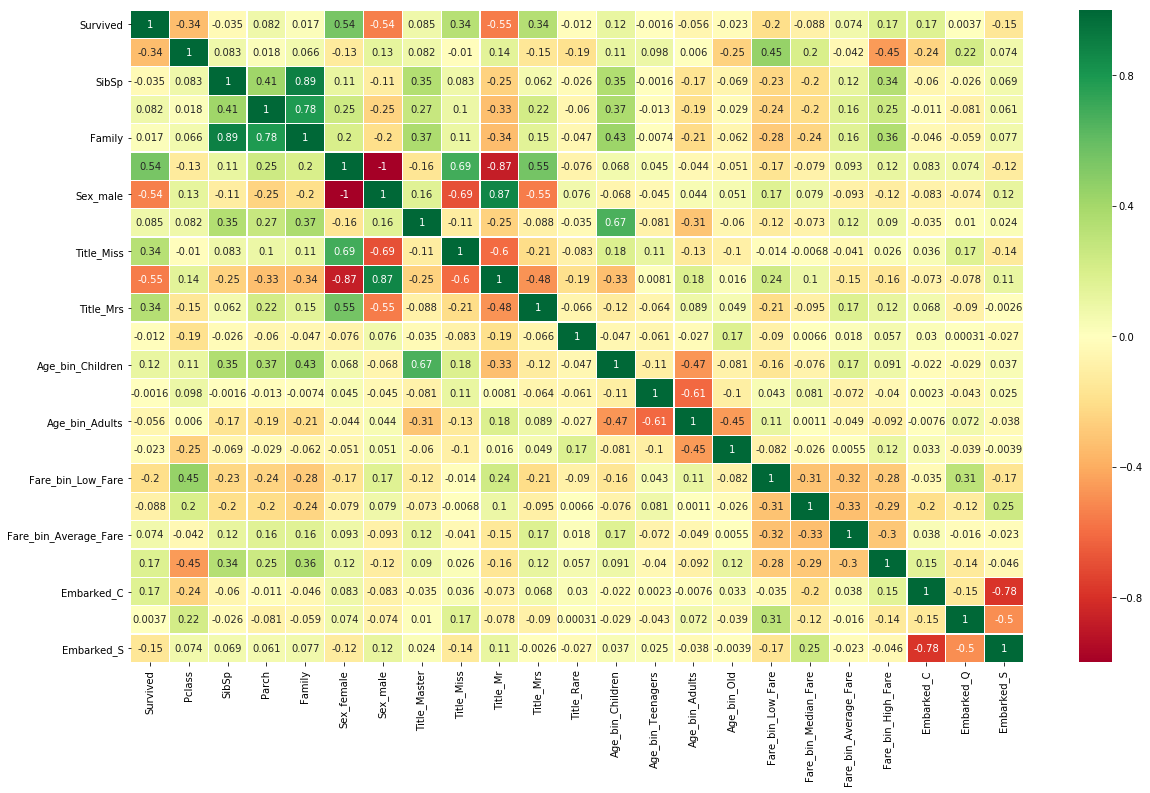

In [147]:
sns.heatmap(traindf.corr(), annot = True, cmap = 'RdYlGn', linewidths = 0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [148]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
all_features = traindf.drop("Survived",axis=1)
Targeted_feature = traindf["Survived"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

In [149]:
testdf.head()

,PassengerId,Pclass,SibSp,Parch,Family,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_bin_Children,Age_bin_Teenagers,Age_bin_Adults,Age_bin_Old,Fare_bin_Low_Fare,Fare_bin_Median_Fare,Fare_bin_Average_Fare,Fare_bin_High_Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
1,893,3,1,0,2,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,894,2,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
3,895,3,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
4,896,3,1,1,3,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1


In [150]:
train_X = traindf.drop("Survived", axis=1)
train_Y=traindf["Survived"]
test_X  = testdf.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 22), (891,), (418, 22))

Important features
____________________________________________________________
89.0


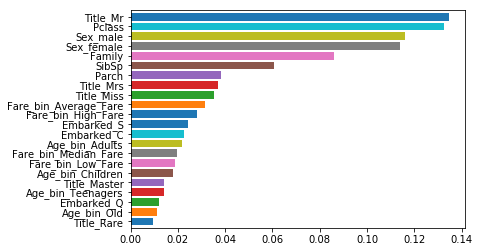

In [151]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
random_forest.fit(train_X, train_Y)
Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X,train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)

print("Important features")
pd.Series(random_forest.feature_importances_,train_X.columns).sort_values(ascending=True).plot.barh(width=0.8)
print('__'*30)
print(acc_random_forest)

In [152]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_rf})

In [153]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [158]:
submission.to_csv('submission.csv', index=False)